# Rasterize Census Data
This notebook walks through rasterizing the census data so that we can use it with the rasterized format of the plots

In [33]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import rasterio as rio

In [26]:
# This code loads the census tract shapefile for Durham County
tracts = gpd.read_file('../data/raw/census/tl_2020_37063_tract20/tl_2020_37063_tract20.shp')

# This code loads the median household income for Durham county
income = pd.read_excel('../data/raw/census/acs_median_income.xlsx', header=1)
income['tract'] = income['Geography'].str.split('US').str[1]
# Extract the tracts that begin with 37063 (Durham)
income = income.loc[income['tract'].str.contains(r'^37063\d.')]

# This code loads the population for Durham county
population = pd.read_csv("../data/raw/census/ACSDP5Y2020.DP05-Data.csv", header=1)
population = population[['Geography','Estimate!!SEX AND AGE!!Total population']]
population['tract'] = population['Geography'].str.split('US').str[1]

# Rename 'Estimate!!SEX AND AGE!!Total population' to population
population.rename({'Estimate!!SEX AND AGE!!Total population':'population'}, axis=1, inplace=True)

# Now, let's merge the dataframes together
df = tracts.merge(income, left_on='GEOID20', right_on='tract')
df = df.merge(population, left_on='GEOID20', right_on='tract')

# Only keep the columns we need:
#  aland, geometry, median income, population
df = df[['GEOID20', 'ALAND20', 'geometry', 'Median Household Income', 'population']]

# Rename columns
df.rename({'ALAND20':'area', 'Median Household Income':'income'}, axis=1, inplace=True)

df.head()

,GEOID20,area,geometry,income,population
0,37063000101,3370322,"POLYGON ((-78.89489 36.02991, -78.89343 36.030...",72382,3716
1,37063000102,3998235,"POLYGON ((-78.91655 36.02532, -78.91635 36.025...",51488,3702
2,37063000200,3021171,"POLYGON ((-78.90299 36.00574, -78.90253 36.006...",52375,3309
3,37063000301,1586355,"POLYGON ((-78.91957 36.01043, -78.91949 36.011...",41750,2826
4,37063000302,1722150,"POLYGON ((-78.91246 36.00396, -78.91243 36.004...",92500,3515


In [27]:
# Add a population density column in 1000 people per square km
df['pop_density'] = df['population'] / df['area'] * 1e3

<Axes: >

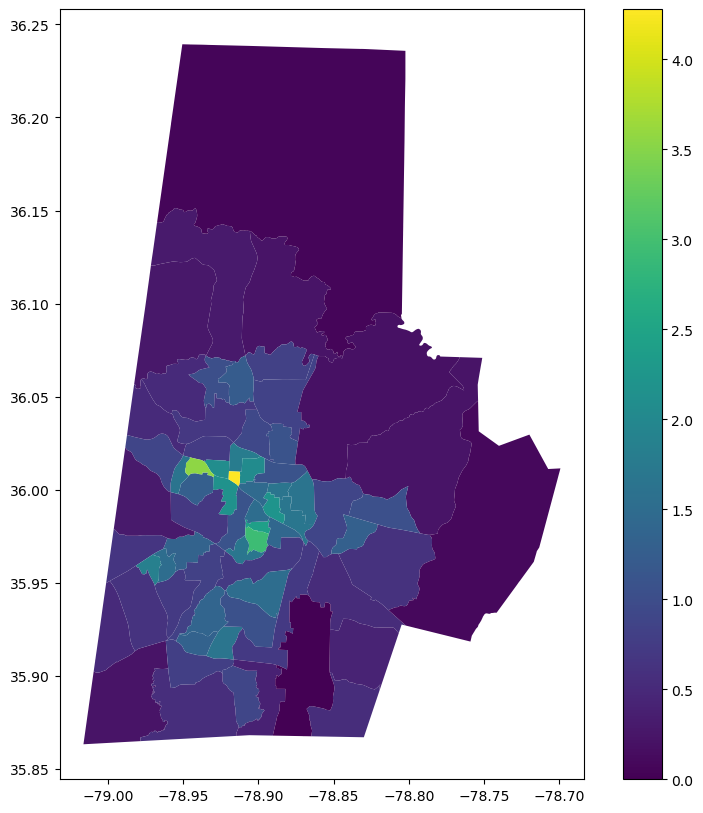

In [28]:
df.plot(column='pop_density', legend=True, figsize=(10,10))

In [30]:
# Save this geopandas to a shapefile
df.to_file('../data/preprocessed/census/census_tracts.shp')

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_5724/2192672821.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file('../data/preprocessed/census/census_tracts.shp')


In [31]:
df.head()

,GEOID20,area,geometry,income,population,pop_density
0,37063000101,3370322,"POLYGON ((-78.89489 36.02991, -78.89343 36.030...",72382,3716,1.102565
1,37063000102,3998235,"POLYGON ((-78.91655 36.02532, -78.91635 36.025...",51488,3702,0.925909
2,37063000200,3021171,"POLYGON ((-78.90299 36.00574, -78.90253 36.006...",52375,3309,1.095271
3,37063000301,1586355,"POLYGON ((-78.91957 36.01043, -78.91949 36.011...",41750,2826,1.781442
4,37063000302,1722150,"POLYGON ((-78.91246 36.00396, -78.91243 36.004...",92500,3515,2.041053


In [35]:
# Now, let's burn these values into a raster that is the same shape
# as the raster used for the weather underground data

# Open the source raster that we would like to copy
with rio.open("../data/preprocessed/temperature/durham_station_count_w_temp_500m.tif") as src:
    bounds = src.bounds
    res = src.res
    data = src.read(1)

print(bounds)
print(res)
print(data.shape)

BoundingBox(left=-8795500.0, bottom=4281000.0, right=-8762000.0, top=4334500.0)
(500.0, 500.0)
(107, 67)


In [47]:
df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [36]:
!ogrinfo ../data/preprocessed/census/census_tracts.shp census_tracts

INFO: Open of `../data/preprocessed/census/census_tracts.shp'
      using driver `ESRI Shapefile' successful.

Layer name: census_tracts
Metadata:
  DBF_DATE_LAST_UPDATE=2024-01-24
Geometry: Polygon
Feature Count: 68
Extent: (-79.016305, 35.863210) - (-78.699316, 36.239320)
Layer SRS WKT:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]
Data axis to CRS axis mapping: 2,1
GEOID20: String (80.0)
area: Integer64 (18.0)
income: String (80.0)
population: Integer64 (18.0)
pop_densit: Real (24.15)
OGRFeature(census_tracts):0
  GEOID20 (String) = 37063000101
  area (Integer6

In [48]:
!gdal_rasterize -to SRC_SRS=EPSG:4269 -a income -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -l census_tracts -tr {res[0]} {res[1]} -a_nodata -9999 -of GTiff -a_srs EPSG:3857 ../data/preprocessed/census/census_tracts.shp ../data/preprocessed/census/census_tracts_income.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [49]:
with rio.open("../data/preprocessed/census/census_tracts_income.tif") as src:
    bounds = src.bounds
    res = src.res
    data = src.read(1)

print(bounds)
print(res)
print(data.shape)

BoundingBox(left=-8795500.0, bottom=4281000.0, right=-8762000.0, top=4334500.0)
(500.0, 500.0)
(107, 67)


In [50]:

np.unique(data)

array([ -9999.,      0.,  23433.,  26600.,  27404.,  29652.,  30645.,
        32877.,  33868.,  34400.,  35679.,  35926.,  35972.,  36691.,
        37879.,  39521.,  39898.,  40543.,  40658.,  41750.,  42016.,
        43272.,  48780.,  49107.,  50194.,  50972.,  51488.,  51698.,
        52375.,  52563.,  56250.,  57697.,  58847.,  59291.,  59773.,
        61250.,  61529.,  63036.,  64880.,  66264.,  66711.,  68950.,
        69967.,  72250.,  72382.,  79917.,  80056.,  80223.,  80300.,
        82265.,  83750.,  86339.,  88764.,  89273.,  89286.,  89327.,
        89736.,  92061.,  92500.,  95163.,  97500.,  99219., 107396.,
       109727., 122845., 151629., 153750.])

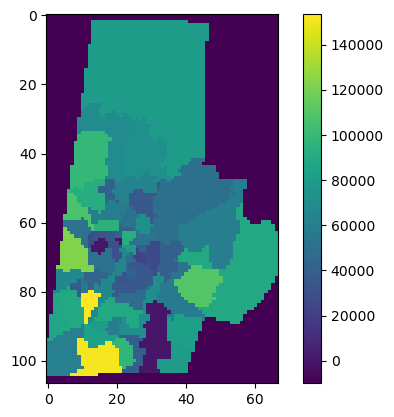

In [51]:
plt.imshow(data, cmap='viridis')
plt.colorbar()

In [58]:
# Population density, now
!gdal_rasterize -to SRC_SRS=EPSG:4269 -a pop_densit -ot Float64 -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -l census_tracts -tr {res[0]} {res[1]} -a_nodata -9999 -of GTiff -a_srs EPSG:3857 ../data/preprocessed/census/census_tracts.shp ../data/preprocessed/census/census_tracts_pop_density.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [71]:
with rio.open("../data/preprocessed/census/census_tracts_pop_density.tif") as src:
    bounds = src.bounds
    res = src.res
    data = src.read(1)

print(bounds)
print(res)
print(data.shape)

BoundingBox(left=-8795500.0, bottom=4281000.0, right=-8762000.0, top=4334500.0)
(500.0, 500.0)
(107, 67)


In [73]:
np.unique(data)

69

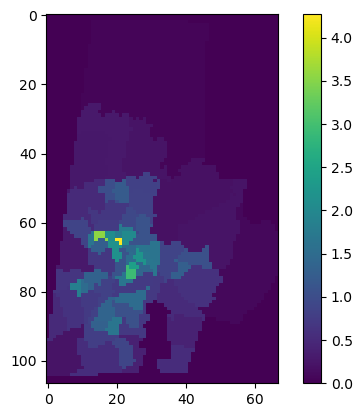

In [62]:
data[data < 0] = 0
plt.imshow(data)
plt.colorbar()

In [68]:
len(np.unique(df['pop_density'].values))

68

In [75]:
# GEOID20
!gdal_rasterize -to SRC_SRS=EPSG:4269 -a GEOID20 -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]} -l census_tracts -tr {res[0]} {res[1]} -a_nodata -9999 -of GTiff -a_srs EPSG:3857 ../data/preprocessed/census/census_tracts.shp ../data/preprocessed/census/census_tracts_geoid.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


BoundingBox(left=-8795500.0, bottom=4281000.0, right=-8762000.0, top=4334500.0)
(500.0, 500.0)
(107, 67)

Unique vals:  [-9.99900000e+03  0.00000000e+00  5.19904183e-02  8.52875866e-02
  1.98227293e-01  2.17416448e-01  2.17944911e-01  2.21406727e-01
  2.79126484e-01  2.86624341e-01  2.95519089e-01  3.90556316e-01
  4.11099513e-01  5.02101690e-01  5.11989401e-01  5.12926969e-01
  5.22895721e-01  5.35190526e-01  5.64136793e-01  6.03308543e-01
  6.20262062e-01  6.56426504e-01  6.95515344e-01  7.01361920e-01
  7.10588757e-01  7.21434509e-01  7.22510798e-01  7.41899548e-01
  7.88457826e-01  8.33334509e-01  8.33647053e-01  8.41739960e-01
  8.73150074e-01  8.77734425e-01  8.91836203e-01  9.25908557e-01
  1.02832079e+00  1.04550748e+00  1.06483354e+00  1.09527067e+00
  1.09855656e+00  1.10256527e+00  1.23139688e+00  1.27720542e+00
  1.29808539e+00  1.32386762e+00  1.34535305e+00  1.37943338e+00
  1.40487346e+00  1.46187712e+00  1.50888705e+00  1.51273059e+00
  1.51881647e+00  1.65073416e+00  1

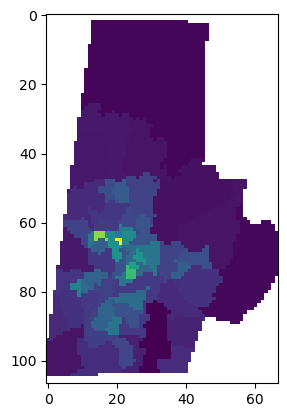

In [77]:
with rio.open("../data/preprocessed/census/census_tracts_pop_density.tif") as src:
    bounds = src.bounds
    res = src.res
    data = src.read(1)

print(bounds)
print(res)
print(data.shape)

print()
print("Unique vals: ", np.unique(data))
print()
print("Length: ", len(np.unique(data)))

data[data < 0] = np.nan
plt.imshow(data)